[View in Colaboratory](https://colab.research.google.com/github/3catz/power_consumption_timeseries/blob/master/Wavelets_and_Stacked_LSTMs_in_time_series_forecasting.ipynb)

# Stacked Bidirectional LSTMs with Attention layers for Time Series Forecasting

The data for this comes from [Comp_Engine Time Series](http://www.comp-engine.org/timeseries/time-series_data/data-17422/), a site which serves as a comparison engine for data and their analysis methods. 

This particular data set is ionospheric parameters (not 100% sure to be honest) measured at the Moscow station. 

In [3]:
#!pip install keras 
#!pip install Prophet
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#import pandas_datareader.data as web
from pandas import Series
from pandas import DataFrame
from pandas import concat

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint

#keras 
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer

#wavelets
import pywt
#import prophet

Using TensorFlow backend.


### **Series to Supervised Code, courtesy of Jason Brownlee**

In [0]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

    



### Attention with Context 

In [0]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
   

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]



# Load the Data

In [124]:
!wget http://www.comp-engine.org/timeseries/query-csv?q=90509
  
  #http://www.comp-engine.org/timeseries/query-csv?q=90509

--2018-07-09 01:01:30--  http://www.comp-engine.org/timeseries/query-csv?q=90509
Resolving www.comp-engine.org (www.comp-engine.org)... 155.198.64.5, 146.179.40.5, 2001:630:12:600:1:2:0:7, ...
Connecting to www.comp-engine.org (www.comp-engine.org)|155.198.64.5|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.comp-engine.org/timeseries/query-csv/?q=90509 [following]
--2018-07-09 01:01:31--  http://www.comp-engine.org/timeseries/query-csv/?q=90509
Reusing existing connection to www.comp-engine.org:80.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/dat]
Saving to: ‘query-csv?q=90509’

query-csv?q=90509       [ <=>                ]  56.25K  --.-KB/s    in 0.1s    

2018-07-09 01:01:32 (576 KB/s) - ‘query-csv?q=90509’ saved [57603]



(14401,)
ADF Statistic: -13.173304
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


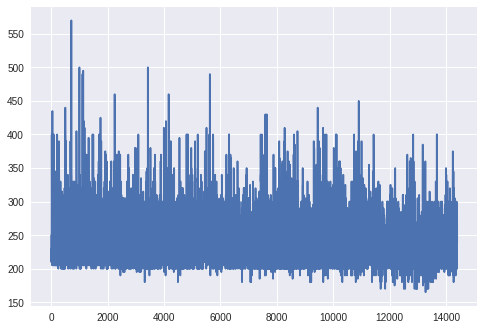

In [125]:
import pandas as pd 

dfx = np.genfromtxt("query-csv?q=90509", delimiter = ",")
plt.plot(dfx)
print(dfx.shape)

from statsmodels.tsa.stattools import adfuller
result = adfuller(dfx)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# ACF and PCF plots

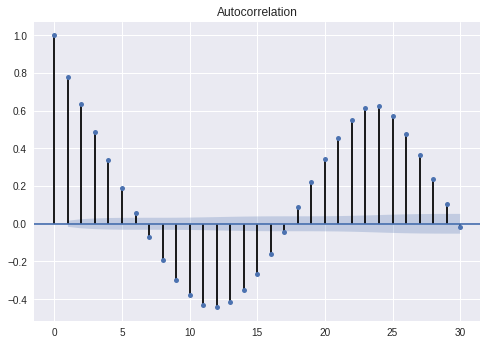

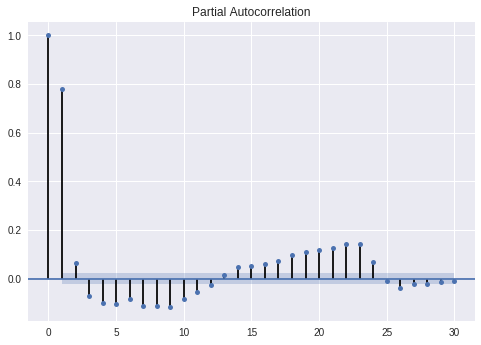

In [127]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(dfx, lags = 30)
plot_pacf(dfx, lags = 30, alpha = .01, use_vlines = True)
plt.show()
length = len(dfx)

# Discrete Wavelet Transform

###  Here we choose the mother wavelet, and the decomposition level, i.e. resolution scales. This is one of the problems with the wavelet methods, you have to choose this mother wavelet a priori, whereas with Huang-Hilbert (EMD) methods you have something more data-driven and adaptive. 

In [0]:
wavelet_type = "db16" #@param {type:"string"}
transform_level = 4 #@param {type:"slider", min:1, max:8, step:1}
modes = "smooth" #@param {type:"string"}


# Wavelet Denoising and smoothing - - using only the approximation coefficients, i.e. eliminating all levels of detail coefficients.

In [0]:
length = len(dfx) 
dfx = dfx.reshape(length,)

In [0]:
cA4, cD4, cD3, cD2, cD1 = pywt.wavedec(dfx, wavelet = wavelet_type, level = transform_level)

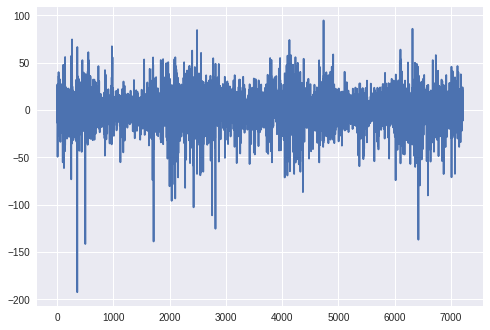

In [131]:
plt.plot(cD1)

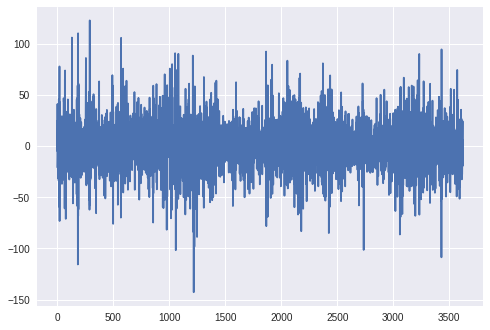

In [132]:
plt.plot(cD2)

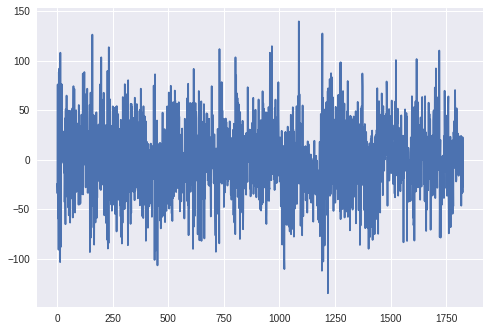

In [133]:
plt.plot(cD3)

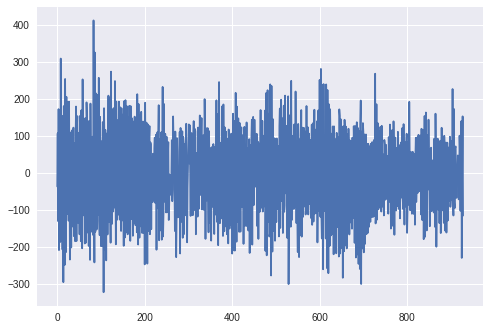

In [134]:
plt.plot(cD4)

# Using the universal threshold adjusted by decomposition level to denoise the detail coefficients at each level. 

1.   Calculate estimated noise variance and then uniersal threshold for that level
2.   Use threshold on the detail coefficients 
3.  Reconstruct original signal 



In [135]:
from statsmodels.robust import mad
sigma1 = mad(cD1)/(.6745)
print(sigma1)
lambda1 = sigma1 * np.sqrt(2*np.log(len(cD1)))
print(lambda1)

18.514001944788184
78.040662595875


In [136]:
sigma2 = mad(cD2)/(.6745)
print(sigma2)
lambda2 = sigma2 * np.sqrt(2*np.log(len(cD2)))
print(lambda2)

31.760731537637763
128.58239250393117


In [137]:
sigma3 = (mad(cD3))/0.6745
print(sigma3)
lambda3 = sigma3 * np.sqrt(2 * np.log(len(cD3)))
print(lambda3)

53.25505126602327
206.39930109429562


In [139]:
sigma4 = (mad(cD4))/0.6745
print(sigma4)
lambda4 = sigma4 * np.sqrt(2 * np.log(len(cD4)))
print(lambda4)

220.40654832409365
814.8551853066389


# Threshold each of the detail coefficient sets with their respective "universal" thresholds.

*soft thresholding

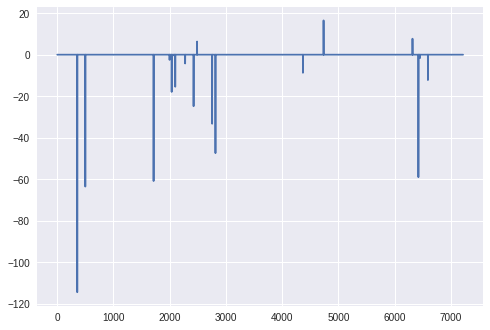

In [140]:
dn_cD1 = pywt.threshold(cD1, value = lambda1, mode = "soft")
plt.plot(dn_cD1)

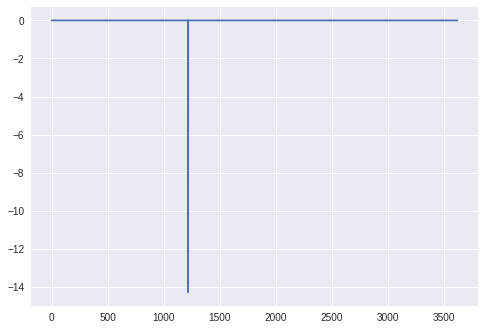

In [141]:
dn_cD2 = pywt.threshold(cD2, value = lambda2, mode = "soft")
plt.plot(dn_cD2)

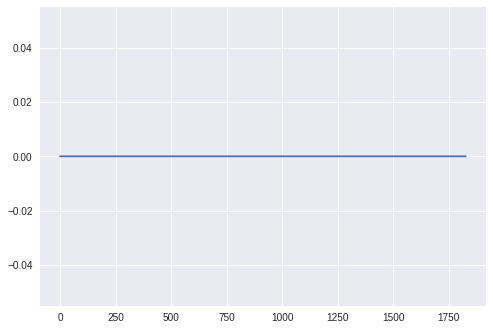

In [142]:
dn_cD3 = pywt.threshold(cD3, value = lambda3, mode = "soft")
plt.plot(dn_cD3)

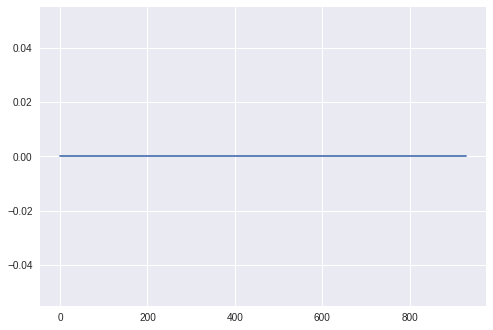

In [143]:
dn_cD4 = pywt.threshold(cD4, value = lambda4, mode = "soft")
plt.plot(dn_cD4)

# Reconstructing the signal 

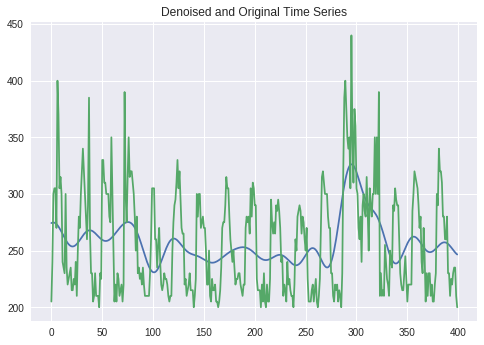

In [145]:
dn_data = pywt.waverec(coeffs = [cA4, dn_cD4, dn_cD3, dn_cD2, dn_cD1], wavelet = wavelet_type, mode = modes)
dn_data = dn_data.reshape(-1,1)

plt.plot(dn_data[200:600])
plt.plot(dfx[200:600])
plt.title("Denoised and Original Time Series")

scaler = MinMaxScaler(feature_range = (-1,1))
dn_data_scaled = scaler.fit_transform(dn_data)  #scale down to (-1,1)

# Transforming the data into a supervised learning problem

1.   Decide the lag times
2.  Decide train test ratio



In [0]:
n_in = 56 #@param {type:"slider", min:0, max:1000, step:2}
n_out = 1 #@param {type:"slider", min:1, max:100, step:1}
testratio = 0.2 #@param {type:"slider", min:0, max:1, step:0.05}


# Create a Supervised Learning Dataset using n_in lags as a sequence which predicts the next value. 

In [171]:
df2 = series_to_supervised(dn_data_scaled, n_in = n_in, n_out = n_out, dropnan = True)
print(df2.shape)
df2 = np.asarray(df2)

(14346, 57)


## Creating Training, Validation and Testing sets

In [172]:
train, test = train_test_split(df2, shuffle = False, test_size = testratio)
valid, test = train_test_split(test, shuffle = False)
train.shape, valid.shape, test.shape

((11476, 57), (2152, 57), (718, 57))

# Reshaping the input for the LSTM shape 

In [173]:
trainX = train[:,:-n_out]
trainY = train[:,-n_out:]
testX = test[:,:-n_out]
testY = test[:,-n_out:]
validX = valid[:,:-n_out]
validY = valid[:,-n_out:]

trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])
validX = validX.reshape(validX.shape[0], 1, validX.shape[1])
print(trainX.shape, validX.shape, testX.shape, trainY.shape, validY.shape, testY.shape)

(11476, 1, 56) (2152, 1, 56) (718, 1, 56) (11476, 1) (2152, 1) (718, 1)


# Model Hyperparameters

In [0]:
#@title neuron, batch, epoch, dropout, callback etc hyperparameters
neurons1 = 32 #@param {type:"integer"}
neurons2 = 32 #@param {type:"number"}
neurons3 = 32 #@param {type:"number"}
epochs = 40 #@param {type:"slider", min:0, max:100, step:1}
dp = 0.4 #@param {type:"slider", min:0, max:1, step:0.05}
d1 = 16 #@param {type:"number"}
d2 = 36 #@param {type:"number"}
myweights = "ionosphere_weights.hdf5" #@param {type:"string"}
bsize = 64 #@param {type:"number"}



# ***The Advanced Model: Bidirectional LSTM layers with Attention Layers in between, followed by fully connected layers. ***





In [192]:
from keras.layers.advanced_activations import *
from keras.regularizers import l2
inputs = Input(shape = (1, n_in))
#first recurrent unit
x = Bidirectional(LSTM(neurons1, return_sequences = True, 
                       dropout = dp, recurrent_dropout = dp), 
                       input_shape = inputs.shape)(inputs)
x = AttentionWithContext()(x)
x = Reshape((1, 2 * neurons1))(x)

#second recurrent unit
x = Bidirectional(LSTM(neurons2, return_sequences = True, 
                  recurrent_dropout = dp, dropout = dp))(x)
x = AttentionWithContext()(x)
x = Reshape((1, 2 * neurons2))(x)
#third recurrent unit

x = Bidirectional(LSTM(neurons3, return_sequences = True, dropout = dp,
                  recurrent_dropout = dp))(x)
x = AttentionWithContext()(x)
x = Reshape((1, 2 * neurons3))(x)

#fourth recurrent unit
x = Bidirectional(LSTM(neurons3, return_sequences = True, dropout = dp,
                      recurrent_dropout = dp))(x)
x = AttentionWithContext()(x)

#first fully connected layer
x = Dense(d1, activation = "relu")(x)
x = Reshape((1, d1))(x)
x = AttentionWithContext()(x)

#last layer, the prediction 
predictions = Dense(n_out, kernel_initializer = "he_normal", 
                    activation = "tanh")(x)

model = Model(inputs = inputs, outputs = predictions)
opt = adam(lr = 1e-3)


#callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor = 0.9, patience = 3, min_lr = 1e-6, verbose = 2)
checkpointer = ModelCheckpoint(filepath = myweights, verbose = 2, save_best_only = True)
early = EarlyStopping(monitor='val_loss', min_delta = 1e-5, patience = 5, verbose = 2, mode = 'auto')

model.compile(optimizer=opt, 
              loss='mse',
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 1, 56)             0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 1, 64)             22784     
_________________________________________________________________
attention_with_context_21 (A (None, 64)                4224      
_________________________________________________________________
reshape_17 (Reshape)         (None, 1, 64)             0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 1, 64)             24832     
_________________________________________________________________
attention_with_context_22 (A (None, 64)                4224      
_________________________________________________________________
reshape_18 (Reshape)         (None, 1, 64)             0         
__________

In [193]:
#@title Fitting the Model
history = model.fit(trainX, trainY, 
          epochs = 50, 
          batch_size = bsize, 
          verbose = 2, 
          validation_data = (validX, validY),
          callbacks = [reduce_lr],
          shuffle = False)

Train on 11476 samples, validate on 2152 samples
Epoch 1/50
 - 31s - loss: 0.0215 - acc: 0.0000e+00 - val_loss: 0.0177 - val_acc: 4.6468e-04
Epoch 2/50
 - 15s - loss: 0.0087 - acc: 0.0000e+00 - val_loss: 0.0190 - val_acc: 4.6468e-04
Epoch 3/50
 - 15s - loss: 0.0076 - acc: 0.0000e+00 - val_loss: 0.0184 - val_acc: 4.6468e-04
Epoch 4/50
 - 15s - loss: 0.0070 - acc: 0.0000e+00 - val_loss: 0.0186 - val_acc: 4.6468e-04

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
Epoch 5/50
 - 14s - loss: 0.0067 - acc: 0.0000e+00 - val_loss: 0.0170 - val_acc: 4.6468e-04
Epoch 6/50
 - 15s - loss: 0.0064 - acc: 8.7138e-05 - val_loss: 0.0164 - val_acc: 4.6468e-04
Epoch 7/50
 - 15s - loss: 0.0063 - acc: 0.0000e+00 - val_loss: 0.0151 - val_acc: 4.6468e-04

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
Epoch 8/50
 - 15s - loss: 0.0060 - acc: 8.7138e-05 - val_loss: 0.0160 - val_acc: 4.6468e-04
Epoch 9/50
 - 15s - loss: 0.0058 - acc: 8.7138e-05 - 

Epoch 30/50
 - 14s - loss: 0.0046 - acc: 8.7138e-05 - val_loss: 0.0074 - val_acc: 4.6468e-04
Epoch 31/50
 - 13s - loss: 0.0045 - acc: 8.7138e-05 - val_loss: 0.0076 - val_acc: 4.6468e-04

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0003486784757114947.
Epoch 32/50
 - 13s - loss: 0.0044 - acc: 8.7138e-05 - val_loss: 0.0074 - val_acc: 4.6468e-04
Epoch 33/50
 - 13s - loss: 0.0046 - acc: 8.7138e-05 - val_loss: 0.0070 - val_acc: 4.6468e-04
Epoch 34/50
 - 13s - loss: 0.0045 - acc: 8.7138e-05 - val_loss: 0.0072 - val_acc: 4.6468e-04

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.00031381062290165574.
Epoch 35/50
 - 13s - loss: 0.0044 - acc: 8.7138e-05 - val_loss: 0.0073 - val_acc: 4.6468e-04
Epoch 36/50
 - 13s - loss: 0.0044 - acc: 8.7138e-05 - val_loss: 0.0071 - val_acc: 4.6468e-04
Epoch 37/50
 - 13s - loss: 0.0044 - acc: 8.7138e-05 - val_loss: 0.0073 - val_acc: 4.6468e-04

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.
Epoch 38/50


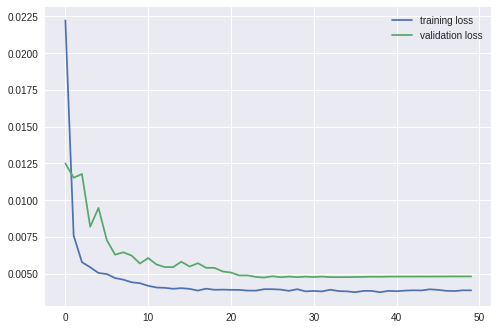

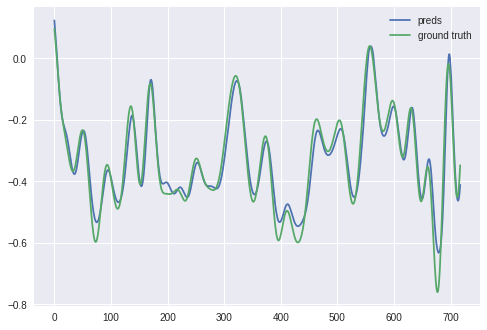

The final R2 score is 0.9382605192734905.
The final RMSE is 0.001474455450396848.


In [188]:
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

preds = model.predict(testX, batch_size = 64)
plt.plot(preds, label = "preds")
plt.plot(testY, label = "ground truth")
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error 

print("The final R2 score is {}.".format(r2_score(testY, preds)))
print("The final RMSE is {}.".format(mean_squared_error(testY,preds)))


# Base Model : also stacked LSTMs (unidirectional)

In [242]:
from keras.layers.advanced_activations import *
from keras.regularizers import l2 
from keras.layers import RepeatVector

inputs = Input(shape = (1, n_in))
#first recurrent unit
x = LSTM(32, return_sequences = True, 
         dropout = dp, 
         recurrent_dropout = dp,
         input_shape = inputs.shape)(inputs)
x = AttentionWithContext()(x)
x = Reshape((1,32))(x)
x = LSTM(16, return_sequences = True, dropout = dp, recurrent_dropout = dp)(x)
x = AttentionWithContext()(x)
predictions = Dense(1, activation = "tanh")(x)

base_model = Model(inputs = inputs, outputs = predictions)


opt = adam(lr = 1e-3)

#callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor = 0.8, patience = 3, min_lr = 9e-4, verbose = 2)
checkpointer = ModelCheckpoint(filepath = myweights, verbose=1, save_best_only = True)
early = EarlyStopping(monitor='val_loss', min_delta = 1e-5, patience = 6, verbose = 2, mode = 'auto')

base_model.compile(optimizer=opt, 
              loss='mse',
              metrics=["accuracy"])
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 1, 56)             0         
_________________________________________________________________
lstm_90 (LSTM)               (None, 1, 32)             11392     
_________________________________________________________________
attention_with_context_66 (A (None, 32)                1088      
_________________________________________________________________
reshape_45 (Reshape)         (None, 1, 32)             0         
_________________________________________________________________
lstm_91 (LSTM)               (None, 1, 16)             3136      
_________________________________________________________________
attention_with_context_67 (A (None, 16)                288       
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 17        
Total para

In [241]:
base_history = base_model.fit(trainX, trainY, 
          epochs = 50, 
          batch_size = 128, 
          verbose = 2, 
          validation_data = (validX, validY),
          callbacks = [reduce_lr],
          shuffle = False)

plt.plot(base_history.history["loss"], label = "training loss")
plt.plot(base_history.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()


base_preds = base_model.predict(testX, batch_size = 128)



Train on 11476 samples, validate on 2152 samples
Epoch 1/50
 - 17s - loss: 0.0232 - acc: 0.0000e+00 - val_loss: 0.0099 - val_acc: 4.6468e-04
Epoch 2/50
 - 23s - loss: 0.0133 - acc: 0.0000e+00 - val_loss: 0.0092 - val_acc: 4.6468e-04
Epoch 3/50
 - 21s - loss: 0.0120 - acc: 0.0000e+00 - val_loss: 0.0106 - val_acc: 4.6468e-04
Epoch 4/50
 - 23s - loss: 0.0111 - acc: 0.0000e+00 - val_loss: 0.0113 - val_acc: 4.6468e-04

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009.
Epoch 5/50
 - 24s - loss: 0.0103 - acc: 8.7138e-05 - val_loss: 0.0106 - val_acc: 4.6468e-04
Epoch 6/50
 - 21s - loss: 0.0102 - acc: 0.0000e+00 - val_loss: 0.0111 - val_acc: 4.6468e-04
Epoch 7/50
 - 4s - loss: 0.0098 - acc: 8.7138e-05 - val_loss: 0.0119 - val_acc: 4.6468e-04
Epoch 8/50
 - 4s - loss: 0.0096 - acc: 8.7138e-05 - val_loss: 0.0119 - val_acc: 4.6468e-04
Epoch 9/50
 - 4s - loss: 0.0096 - acc: 8.7138e-05 - val_loss: 0.0113 - val_acc: 4.6468e-04
Epoch 10/50
 - 30s - loss: 0.0095 - acc: 8.7138e-05 - val_lo

KeyboardInterrupt: ignored

Final R2 Score is: 0.8722004767993357


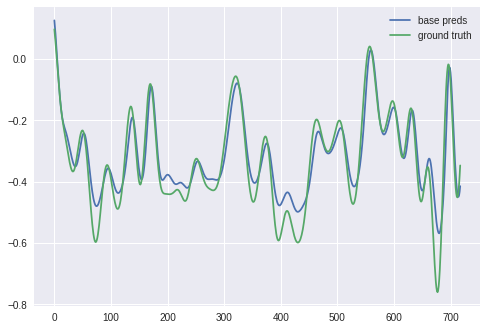

In [218]:
plt.plot(base_preds, label = "base preds")
plt.plot(testY, label = "ground truth")
print("Final R2 Score is: " + str(r2_score(testY, base_preds)))
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()

In [58]:
from scipy import signal
f, Sk = signal.periodogram(stationary, nfft = len(stationary_scaled), return_onesided = True, scaling = "spectrum")
 # Check that sum(Sk) equals variance of x
#np.sum(Sk) == np.var(df_rec_scaled)


NameError: ignored

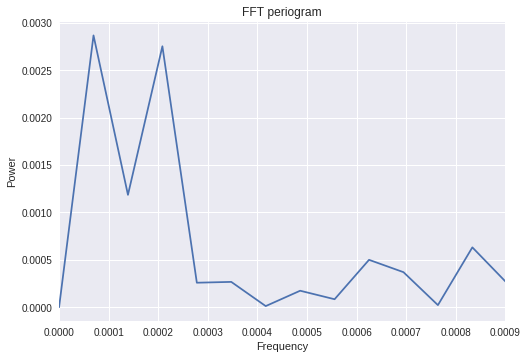

In [184]:
import pyageng
plt.xlim([0,.0009])
pyageng.pfft(dn_data_scaled[:,0], scaling = "spectrum")


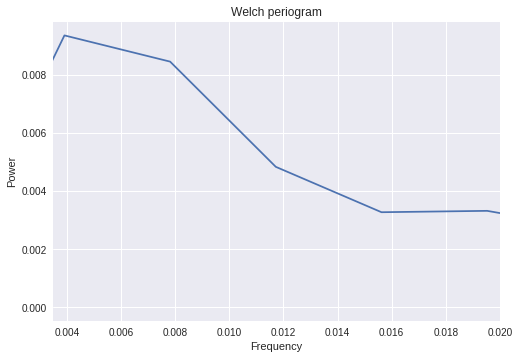

In [185]:
import scipy 
plt.xlim([.0035,.02])
pyageng.pwelch(dn_data_scaled[:,0], scaling = "spectrum", window = "hanning")

In [169]:
.0039 * length

56.1639